# Logistic Regression and Stochastic Gradient Descent

In [8]:
# import Data set
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

iteration_times = 400   
train_valid_ratio = 0.9   

In [9]:
# lode Data
a_train = load_svmlight_file('./DATA/a9a')
a_test = load_svmlight_file('./DATA/a9a.t', n_features=a_train[0].shape[1])
print('\n')
print('This value train and test data')
print('Train Data Shape :', a_train[0].shape, 'Test Data Shape:', a_test[0].shape)
print('Each sample has  : 123/123 ')



This value train and test data
Train Data Shape : (32561, 123) Test Data Shape: (16281, 123)
Each sample has  : 123/123 


In [10]:
# Return Train &  Validation

def prepare_data(train, test, shuffle = False):
    x_train, y_train, x_valid, y_valid = train[0], train[1], test[0], test[1]

    y_train[y_train == -1] = 0
    y_valid[y_valid == -1] = 0
    return x_train, x_valid, y_train, y_valid

In [11]:
def init_param(n, method='randn', scale=0.01):

  #  initilize param
  
    if n < 0:
        return
    if method == 'randn':
        if n > 1:
            return scale * np.random.random(size=n)
        else:
            return scale * np.random.random()
    if method == 'zero':
        if n > 1:
            return np.zeros(n)
        else:
            return 0

In [12]:
# Choose loss function, calculate gradient and update params
def logistic_model(x, w):
    try:
        y = 1 / (1 + np.exp(-x * w))
        return y
    except Exception as e:
        print("THE VALUE X don't Match W")


def loss_function(y, y_pred):
    return -1 * np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))  # use log loss function

def compute_gradient(x, y, y_pred):
    # compute gradient, perhaps different loss fucntion.
    return (y_pred - y) * x / x.shape[0]


def get_batch(x, batch_size=20):
    if batch_size < 0:
        return
    # default batch_size 20
    return np.random.choice(range(x.shape[0]) , size=batch_size)

#*********************** Update  NGA *********************************
def update_params_nga(x, y, y_pred, w, v, mu, alpha):

    d_w = compute_gradient(x, y, y_pred)  # evaluate dx_head
    v_prev = v
    v = mu * v - alpha * d_w  # alpha is learning rate
    w = w + mu * v_prev + (1 + mu) * v
    return w, v
 
#************************ Update RMSprop*********************************
def update_params_rmsprop(x, y, y_pred, w, cache, decay_rate, eps, alpha):

    d_w = compute_gradient(x, y, y_pred)  # alpha is learning rate, compute the gradient of w
    cache = decay_rate * cache + (1 - decay_rate) * (d_w ** 2) 
    w = w - alpha * d_w / (np.sqrt(cache) + eps)  # update weight
    return w, cache

#*************************** Update adadelta *********************************************
def update_params_adadelta(x, y, y_pred, w, decay_rate, eps, cum_grad, cum_u_w, u_w_list):

    # Comput Root Mean square of Cumulative Gradient
    d_w = compute_gradient(x, y, y_pred)  # alpha is learning rate
    cum_grad = decay_rate * cum_grad + (1 - decay_rate) * (d_w ** 2)
    rms_grad = np.sqrt(cum_grad + eps)

    # Comput Root Mean Square Of Cumulative Update Value of w
    cum_u_w = decay_rate * cum_u_w + (1 - decay_rate) * (u_w_list[-1] ** 2)
    rms_u_w = np.sqrt(cum_u_w + eps)

    # Update weight
    u_w = rms_u_w * d_w / rms_grad
    w = w - u_w  # alpha is learning rate

    # Store params
    u_w_list.append(u_w)

    return w, cum_grad, cum_u_w

#********************************* Update Adam **********************************************

def update_params_adam(x, y, y_pred, w, m, v, betal_one, belta_two, eps, alpha, iter_step):


    d_w = compute_gradient(x, y, y_pred)  # alpha is learning rate, compute the gradient of w
    m = betal_one * m + (1 - betal_one) * d_w
    mt = m / (1 - np.power(betal_one, iter_step + 1))
    v = belta_two * v + (1 - belta_two) * (d_w ** 2)
    vt = v / (1 - np.power(belta_two, iter_step + 1))
    w = w - alpha * mt / (np.sqrt(vt) + eps)
    return w, m, v

In [13]:
#  Different Method Of Updating Params
def nga_model(x_train, x_valid, y_train, y_valid, iteration_times, mu, alpha):

    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    v = init_param(x_train.shape[1], method='zero')  # initial with zeros
    for i in range(iteration_times):
        # Get Train & Test Data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # Logistic Model & Train loss
        y_pred = logistic_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred)  # square loss function of train data
        train_loss.append(loss_t)

        # Logistic Model & Validation loss
        y_valid_pred = logistic_model(x_valid, w)
        loss_v = loss_function(y_valid, y_valid_pred)  # square loss function of validation data
        valid_loss.append(loss_v)


        w, v = update_params_nga(x_train_batch, y_train_batch, y_pred, w, v, mu, alpha)

    return train_loss, valid_loss

#************************** RMS prop_model  *************************
def rmsprop_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps, alpha):
    # decay_rate: decay rate, eps: hyperparameter,, alpha: learning rate
    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    cache = init_param(1, method='zero')  # initial with zeros
    for i in range(iteration_times):
        # get batch train and test data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # logistic model, and train loss
        y_pred = logistic_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred)  # square loss function of train data
        train_loss.append(loss_t)

        # logistic model, and validation loss
        y_valid_pred = logistic_model(x_valid, w)
        loss_v = loss_function(y_valid, y_valid_pred)  # square loss function of validation data
        valid_loss.append(loss_v)
 

        w, cache = update_params_rmsprop(x_train_batch, y_train_batch, y_pred, w, cache, decay_rate, eps, alpha)
    
    return train_loss, valid_loss

#******************   Adadelta Model ****************************
def adadelta_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps):
    
    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    cum_grad = init_param(1, method='zero')  # initial with zero
    cum_u_w = init_param(1, method='zero')  # initial with zero
    u_w_list = [init_param(x_train.shape[1], method='zero')]

    for i in range(iteration_times):
        # get batch train and test data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # logistic model, and train loss
        y_pred = logistic_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred)  # square loss function of train data
        train_loss.append(loss_t)

        # logistic model, and validation loss
        y_valid_pred = logistic_model(x_valid, w)
        loss_v = loss_function(y_valid, y_valid_pred)  # square loss function of validation data
        valid_loss.append(loss_v)

        w, cum_grad, cum_u_w = update_params_adadelta(x_train_batch, y_train_batch, y_pred, w, decay_rate, eps, cum_grad, cum_u_w,
                                                      u_w_list)

    return train_loss, valid_loss

#************************************ Adam Model*******************************************************

def adam_model(x_train, x_valid, y_train, y_valid, iteration_times, betal_one, belta_two, eps, alpha):

    train_loss = []
    valid_loss = []
    # initial params
    w = init_param(x_train.shape[1])  # initialize weight and bias
    m = init_param(1, method='zero')  # initial with zero
    v = init_param(1, method='zero')  # initial with zero

    for i in range(iteration_times):
        # Get Train & Test data
        index = get_batch(x_train, batch_size=int(x_train.shape[0]/iteration_times))
        x_train_batch = x_train[index, :]
        y_train_batch = y_train[index]

        # Logistic Model & Train loss
        y_pred = logistic_model(x_train_batch, w)
        loss_t = loss_function(y_train_batch, y_pred)  # square loss function of train data
        train_loss.append(loss_t)

        # Logistic Model & Validation loss

        y_valid_pred = logistic_model(x_valid, w)

        loss_v = loss_function(y_valid, y_valid_pred)  # square loss function of validation data
        valid_loss.append(loss_v)


        w, m, v = update_params_adam(x_train_batch, y_train_batch, y_pred, w, m, v, betal_one, belta_two, eps, alpha, i)
    return train_loss, valid_loss


In [14]:
# beside that, we can adjust some hyper params
x_train, x_valid, y_train, y_valid = prepare_data(a_train, a_test)  # prepare train and test data
train_total_loss = []  # train loss value
valid_total_loss = []  # test loss value

mu = 0.9  # momentum
alpha = [0.1, 0.01, 0.001]  # learning rate
decay_rate = 0.9  # Decay Rate
eps = 1e-8  # hyprparameter
betal_one = 0.9
betal_two = 0.99

nga_total_train_loss = []
nga_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = nga_model(x_train, x_valid, y_train, y_valid, iteration_times, mu, a)
    nga_total_train_loss.append(train_loss)
    nga_total_valid_loss.append(valid_loss)

rmsprop_total_train_loss = []
rmsprop_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = rmsprop_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps, a)
    rmsprop_total_train_loss.append(train_loss)
    rmsprop_total_valid_loss.append(valid_loss)

adadelta_total_train_loss = []
adadelta_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = adadelta_model(x_train, x_valid, y_train, y_valid, iteration_times, decay_rate, eps)
    adadelta_total_train_loss.append(train_loss)
    adadelta_total_valid_loss.append(valid_loss)

adam_total_train_loss = []
adam_total_valid_loss = []
for a in alpha:
    train_loss, valid_loss = adam_model(x_train, x_valid, y_train, y_valid, iteration_times, betal_one, betal_two, eps, a)
    adam_total_train_loss.append(train_loss)
    adam_total_valid_loss.append(valid_loss)


**************************************************************** 
This Result Logistic Regression and Stochastic Gradient Descent 
**************************************************************** 


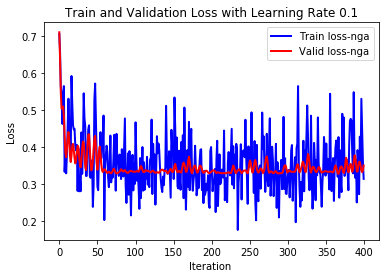

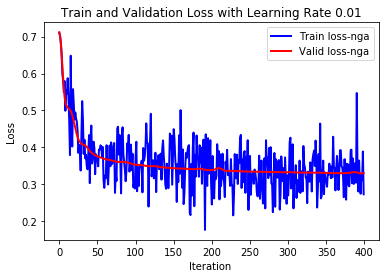

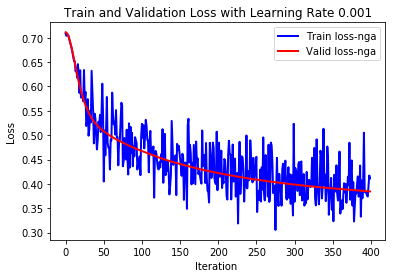

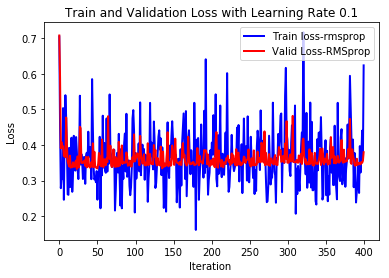

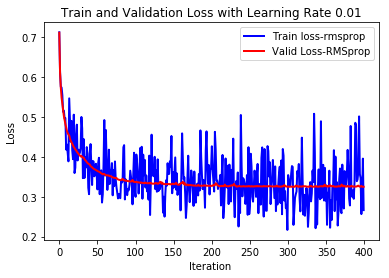

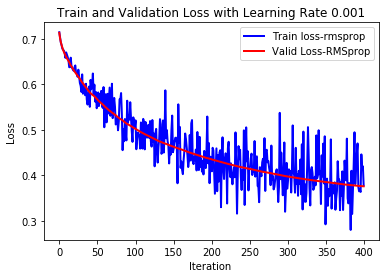

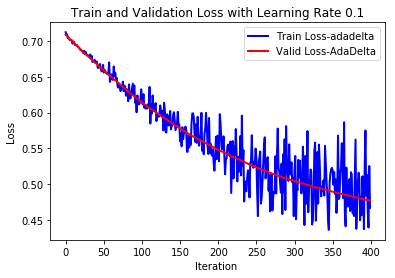

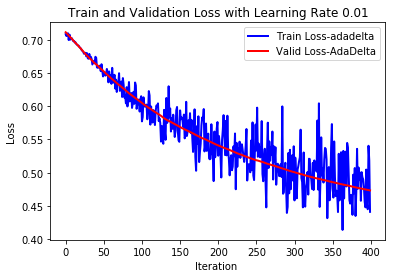

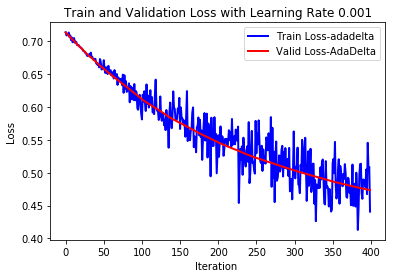

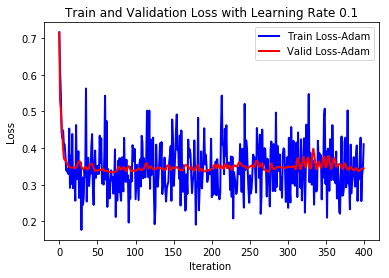

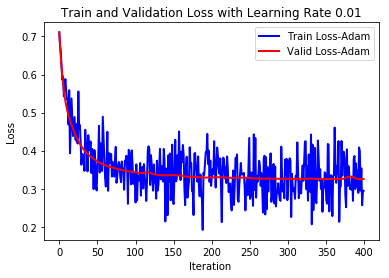

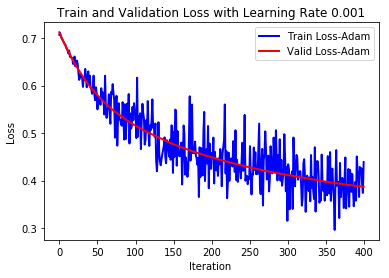

In [18]:
#****************** Draw The Graph Of Train And Validation 

import matplotlib.pyplot as PL


print("**************************************************************** ")
print("This Result Logistic Regression and Stochastic Gradient Descent ")
print("**************************************************************** ")

def plot_result(train_loss, valid_loss, fig_config):

    for i in range(len(alpha)):
        PL.figure()
        PL.title('Train and Validation Loss with Learning Rate '+ str(alpha[i]))
        PL.plot(range(len(train_loss[i])), train_loss[i], linewidth=2.0,
                 color=fig_config['color'][0], label=fig_config['label'][0])
        PL.plot(range(len(valid_loss[i])), valid_loss[i], linewidth=2.0,
                 color=fig_config['color'][1], label=fig_config['label'][1])
        PL.xlabel('Iteration ')
        PL.ylabel('Loss ')
        PL.legend(fig_config['label'])
        PL.show()
        print('\n')
# plot params
fig_config = {    # train line
    'label':['Train loss-nga', 'Valid loss-nga'],     # validation line
    'color': ['b', 'r'],
}
plot_result(nga_total_train_loss, nga_total_valid_loss, fig_config)



fig_config = {   
    'label':['Train loss-rmsprop', 'Valid Loss-RMSprop'],     
    'color': ['b', 'r'],
}
plot_result(rmsprop_total_train_loss, rmsprop_total_valid_loss, fig_config)


fig_config = {    
    'label':['Train Loss-adadelta', 'Valid Loss-AdaDelta'],     
    'color': ['b', 'r'],
}
plot_result(adadelta_total_train_loss, adadelta_total_valid_loss, fig_config)


fig_config = {    
    'label':['Train Loss-Adam', 'Valid Loss-Adam'],     
    'color': ['b', 'r'],
}
plot_result(adam_total_train_loss, adam_total_valid_loss, fig_config)

print('\n')
print('\n')